In [4]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Functions

In [5]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')
    
def bootstrap_slope(table, x, y, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter, get the slope of the regression line,
    # augment the list of generated slopes
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)
    
    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)

def fitted_value(table, x, y, given_x):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * given_x  + b

def bootstrap_prediction(table, x, y, new_x, repetitions):
    
    # For each repetition:
    # Bootstrap the scatter; 
    # get the regression prediction at new_x; 
    # augment the predictions list
    predictions = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = table.sample()
        bootstrap_prediction = fitted_value(bootstrap_sample, x, y, new_x)
        predictions = np.append(predictions, bootstrap_prediction)
        
    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    
    # Prediction based on original sample
    original = fitted_value(table, x, y, new_x)
    
    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Height of regression line at x='+str(new_x)+':', original)
    print('Approximate 95%-confidence interval:')
    print(left, right)

## SleepStudy

In [6]:
SleepStudy = Table.read_table('SleepStudy.csv')
SleepStudy.show(3)

Gender,ClassYear,LarkOwl,NumEarlyClass,EarlyClass,GPA,ClassesMissed,CognitionZscore,PoorSleepQuality,DepressionScore,AnxietyScore,StressScore,DepressionStatus,AnxietyStatus,Stress,DASScore,Happiness,AlcoholUse,Drinks,WeekdayBed,WeekdayRise,WeekdaySleep,WeekendBed,WeekendRise,WeekendSleep,AverageSleep,AllNighter
0,4,Neither,0,0,3.6,0,-0.26,4,4,3,8,normal,normal,normal,15,28,Moderate,10,25.75,8.7,7.7,25.75,9.5,5.88,7.18,0
0,4,Neither,2,1,3.24,0,1.39,6,1,0,3,normal,normal,normal,4,25,Moderate,6,25.7,8.2,6.8,26,10,7.25,6.93,0
0,4,Owl,0,0,2.97,12,0.38,18,18,18,9,moderate,severe,normal,45,17,Light,3,27.44,6.55,3,28,12.59,10.09,5.02,0


## Can DASScore predict Happiness?

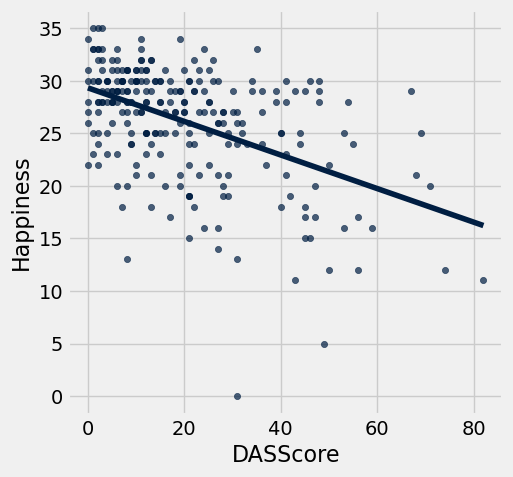

In [7]:
SleepStudy.scatter('DASScore','Happiness', fit_line=True)

In [8]:
correlation(SleepStudy, 'DASScore', 'Happiness')

-0.48106334278310603

In [9]:
slope(SleepStudy, 'DASScore', 'Happiness')

-0.15961148858565588

In [10]:
intercept(SleepStudy, 'DASScore', 'Happiness')

29.309210462961563

## Residual Diagnostics

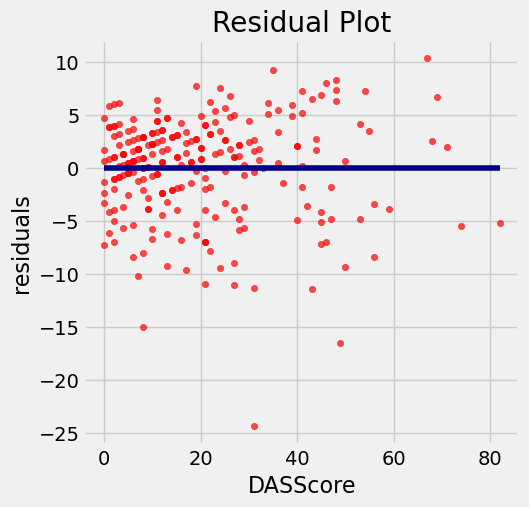

In [11]:
residual_plot(SleepStudy, 'DASScore', 'Happiness')

## What does this say about the population?

**Null Hypothesis.** Slope of true line = 0.

**Alternative Hypothesis.** Slope of true line is not 0.

Slope of regression line: -0.159611488586
Approximate 95%-confidence interval for the true slope:
-0.200692003843 -0.117137493726


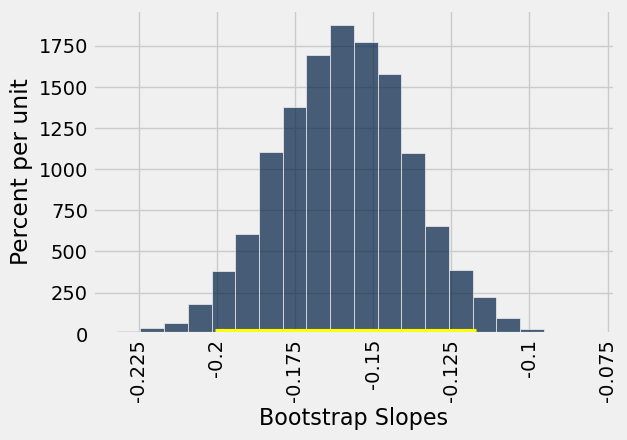

In [12]:
bootstrap_slope(SleepStudy, 'DASScore', 'Happiness', 5000)

In [13]:
mean_DASScore = np.mean(SleepStudy.column('DASScore'))
mean_DASScore

20.039525691699605

In [14]:
fitted_value(SleepStudy, 'DASScore', 'Happiness', mean_DASScore)

26.110671936758894

Height of regression line at x=20.0395256917: 26.1106719368
Approximate 95%-confidence interval:
25.5086616106 26.6941141385


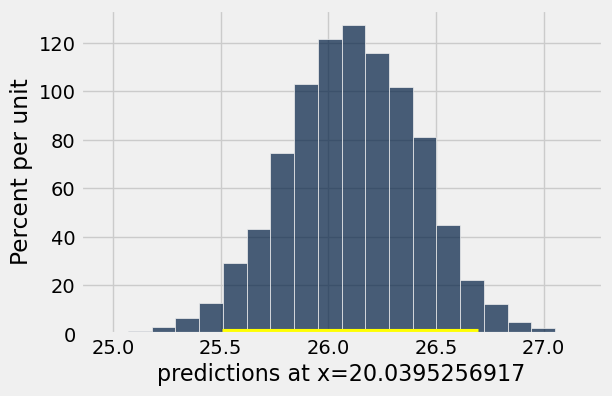

In [15]:
bootstrap_prediction(SleepStudy, 'DASScore', 'Happiness', mean_DASScore, 5000)

## Minimizing RMSE and extensions to more complex models

In [16]:
def Sleep_DAS_Hap_mse(any_slope, any_intercept):
    x = SleepStudy.column('DASScore')
    y = SleepStudy.column('Happiness')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [17]:
minimize(Sleep_DAS_Hap_mse)

array([ -0.15961149,  29.30921049])

In [18]:
slope(SleepStudy, 'DASScore', 'Happiness'), intercept(SleepStudy, 'DASScore', 'Happiness')

(-0.15961148858565588, 29.309210462961563)

In [19]:
def Sleep_DAS_Hap_mse(a, b, c, d, e, f):
    x1 = SleepStudy.column('DASScore')
    x2 = SleepStudy.column('GPA')
    x3 = SleepStudy.column('PoorSleepQuality')
    x4 = SleepStudy.column('Drinks')
    x5 = SleepStudy.column('AverageSleep')
    y = SleepStudy.column('Happiness')
    fitted = a*x1 + b*x2 + c*x3 + d*x4 + e*x5 + f
    return np.mean((y - fitted) ** 2)

In [20]:
coefficients = minimize(Sleep_DAS_Hap_mse)
coefficients

array([ -0.13863724,   0.18186849,  -0.28461076,  -0.13722481,
         0.18866189,  29.34109947])

In [21]:
coefficients.item(0)*20 + coefficients.item(1)*3.2 + coefficients.item(2)*19 + \
coefficients.item(3)*4 + coefficients.item(4)*6.5 + coefficients.item(5)

22.42013243442007